In [29]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
# from lightgbm import LGBMClassifier
from scipy import stats

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, SGDRegressor
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFECV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.base import clone
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import MiniBatchKMeans

In [2]:
# Read in data from github
url_accident = "https://github.com/BradenAnderson/Accident_Severity_Prediction/blob/main/Data/accident.csv.gz?raw=tr"
url_vehicle = "https://github.com/BradenAnderson/Accident_Severity_Prediction/blob/main/Data/vehicle.csv.gz?raw=tr"
url_person = "https://github.com/BradenAnderson/Accident_Severity_Prediction/blob/main/Data/person.csv.gz?raw=tr"

accident = pd.read_csv(url_accident,compression='gzip')
vehicle = pd.read_csv(url_vehicle, compression='gzip', low_memory=False, encoding="ISO-8859-1")
person = pd.read_csv(url_person, compression='gzip', low_memory=False, encoding="ISO-8859-1")

In [3]:
# Filter accidents where driver is present and vehicle is involved
person = person.loc[(person.VEH_NO==1) & (person.PER_NO==1)]
vehicle = vehicle.loc[vehicle.VEH_NO==1]

# Left join person with vehicle and accident
# Duplicated CASENUM are dropped
df = person.merge(vehicle.drop_duplicates(subset=['CASENUM']), on='CASENUM', how='left')
df = df.merge(accident.drop_duplicates(subset=['CASENUM']),on='CASENUM',how='left')

# Comprehensive list of variables used in this analysis
# ORIGINAL features from lab 1 / EDA: regionname, urbanicityname, body_typname, makename, mod_yearname, vtrafwayname, vnum_lanname, vsurcondname, vtrafconname, 
                                # typ_intname, int_hwyname, weathername, wkdy_imname, reljct1_imname, lgtcon_imname, maxsev_imname, alchl_imname, age_im, sex_imname, trav_sp
# DERIVED features: hour_binned, speeding_status
# NEW features post-lab 1 / EDA: rest_usename, pcrash1_imname, weather_binned (binning of `weathername`), body_type_binned (binning of `body_typname`), int_binned (binning of `typ_intname`)
# DISCARDED features that were not useful: hour_imname (unnecessary with `hour_binned`), vspd_lim (unnecessary with `speeding_status`), makename (too many levels), wrk_zonename

df = df[['REGIONNAME','URBANICITYNAME','BODY_TYPNAME_x', 'MOD_YEARNAME_x','VTRAFWAYNAME','VNUM_LANNAME','VSURCONDNAME','VTRAFCONNAME','TYP_INTNAME','INT_HWYNAME','WEATHERNAME',
        'WKDY_IMNAME', 'RELJCT1_IMNAME','LGTCON_IMNAME','MAXSEV_IMNAME','ALCHL_IMNAME','AGE_IM','SEX_IMNAME','TRAV_SP','REST_USENAME','PCRASH1_IMNAME','HOUR_IMNAME','VSPD_LIM',
        'HOUR_IM']]

df = df.rename(columns=str.lower)
df.shape

(54473, 24)

In [4]:
# Remove NA values since they are low representation of the entire dataset
df.dropna(inplace=True)

# Remove unknown instances, convert to numeric dtype
non_int_values = pd.to_numeric(df.mod_yearname_x, errors='coerce').isna()
df = df[-non_int_values]
df['mod_yearname_x'] = pd.to_numeric(df['mod_yearname_x'])

# Filter to years 1980+
df = df.loc[df['mod_yearname_x'] >= 1980]

# trav_sp
# Speed Greater Than 151 mph indicated as 997
# Speed not reported indicated as 998
# Speed reported as unknown indicated as 999
# Discern number of rows lost if 997, 998, and 998 are removed
# 28975 !! Will impute instead
df.loc[df['trav_sp'] >= 997].shape[0]

# regionname
df.loc[:, "regionname"] = df.loc[:,"regionname"].apply(lambda string: string.split()[0])


# urbanicityname
df["urbanicityname"] = df.loc[:,"urbanicityname"].apply(lambda string: string.split()[0])

# Bin observations 'Not Reported', 'Reported as Unknown' into NR/UNK
df['vtrafwayname'] = df['vtrafwayname'].replace(['Not Reported', 'Reported as Unknown'], 'NR/UNK')

# Bin 'Not Reported', 'Reported as Unknown', 'Other' as NR/UNK/OTH
df['vsurcondname'] = df['vsurcondname'].replace(['Not Reported', 'Reported as Unknown', 'Other'], 'NR/UNK/OTH')

# Bin 'Not Reported', 'Other Regulatory Sign', 'Other', 'Reported as Unknown', 'Other Highway Traffic Signal', 'Unknown Highway Traffic Signal', 'Unknown Regulatory Sign'
df['vtrafconname'] = df['vtrafconname'].replace(['Not Reported', 'Other Regulatory Sign', 'Other', 
                                                 'Reported as Unknown', 'Other Highway Traffic Signal', 
                                                 'Unknown Highway Traffic Signal', 'Unknown Regulatory Sign'], 'NR/UNK/OTH')

# Drop observations with Unknown
df.drop(df[df['int_hwyname'] == 'Unknown'].index, inplace = True)

In [5]:
def create_speeding_feature(row):
    
    # Speed greater than 151 mph, you're speeding
    if row["trav_sp"] == 997:
        return 'speeding'
    
    # If we know they were going 95 mph or faster, calling that speeding
    # regardless of what the speed limit is, or if we even know ths speed limit.
    elif row["trav_sp"] < 152 and row["trav_sp"] >= 95:
        return 'speeding'
    
    # If the speed limit is unknown, speeding is unknown
    elif row["vspd_lim"] == 98 or row["vspd_lim"] == 99:
        return 'unknown'
    
    # If the traveling speed is unknown, speeding is unknown
    elif row['trav_sp'] == 998 or row['trav_sp'] == 999:
        return 'unknown'
    
    # If traveling faster than the speed limit, speeding
    elif row['trav_sp'] > row['vspd_lim']:
        return 'speeding'
    else:
        return 'not speeding'
    
df["speeding_status"] = df.apply(lambda row: create_speeding_feature(row), axis='columns')

def create_binned_hours_feature(numeric_hour, night_hours=[0,1,2,3,4,21,22,23], morning_hours=[5,6,7,8,9,10,11], 
                                afternoon_hours=[12,13,14,15], evening_hours=[16,17,18,19,20]):
    
    # NOTE: numeric_hour is a value from the HOUR_IM column

    # Default for night is 9pm-4:59am
    if numeric_hour in night_hours:
        return "Night"
    
    # Default for morning is 5am-11:59am
    elif numeric_hour in morning_hours:
        return "Morning"
    
    # Default for Afternoon is 12:00pm-3:59pm
    elif numeric_hour in afternoon_hours:
        return "Afternoon"
    
    # Default for evening is 4:00pm-8:59pm
    elif numeric_hour in evening_hours:
        return "Evening"
    
df["hour_binned"] = df["hour_im"].apply(lambda hour: create_binned_hours_feature(numeric_hour=hour))

# After hour_im is used to create hour_binned, we no longer need hour_im
df.drop(columns="hour_im", inplace=True)

In [6]:
df['body_type_binned']=df['body_typname_x']

df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['4-door sedan, hardtop',
                                       '2-door sedan,hardtop,coupe',
                                       '3-door coupe','Sedan/Hardtop, number of doors unknown'
                                        ],value=1)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        'Compact Utility (Utility Vehicle Categories \"Small" and \"Midsize\")',
                                         value=2)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                                      ["Auto-based pickup (includes E1 Camino, Caballero, Ranchero, SSR, G8-ST, Subaru Brat, Rabbit Pickup)",
                                        "Light Pickup",
                                        "Unknown (pickup style) light conventional truck type",
                                        "Unknown light truck type",
                                        "Unknown light vehicle type (automobile,utility vehicle, van, or light truck)",
                                        'Light Vehicle Based Motor Home (chassis mounted)'
                                        ],value=3)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                         ['Large utility (ANSI D16.1 Utility Vehicle Categories and "Full Size" and "Large")',
                                        'Utility Vehicle, Unknown body type'
                                         ],value=4)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['ATV/ATC [All-Terrain Cycle]',
                                        'Moped or motorized bicycle',
                                        'Motor Scooter',
                                        'Off-road Motorcycle',
                                        'Other motored cycle type (mini-bikes, pocket motorcycles "pocket bikes")',
                                        'Three-wheel Motorcycle (2 Rear Wheels)',
                                        'Two Wheel Motorcycle (excluding motor scooters)',
                                        'Unenclosed Three Wheel Motorcycle / Unenclosed Autocycle (1 Rear Wheel)',
                                        'Unknown motored cycle type',
                                        'Unknown Three Wheel Motorcycle Type'
                                        ],value=5)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Station Wagon (excluding van and truck based)',
                                        'Utility station wagon (includes suburban limousines, Suburban, Travellall, Grand Wagoneer)'
                                        ],value=6)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['3-door/2-door hatchback',
                                        '5-door/4-door hatchback',
                                        'Hatchback, number of doors unknown'
                                        ],value=7)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Cross Country/Intercity Bus',
                                        'Medium/Heavy Vehicle Based Motor Home',
                                        'Other Bus Type',
                                        'School Bus',
                                        'Transit Bus (City Bus)',
                                        'Unknown Bus Type'
                                        ],value=8)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Cab Chassis Based (includes Rescue Vehicle, Light Stake, Dump, and Tow Truck)',
                                        'Medium/heavy Pickup (GVWR greater than 10,000 lbs.)',
                                        'Single-unit straight truck or Cab-Chassis (GVWR greater than 26,000 lbs.)',
                                        'Single-unit straight truck or Cab-Chassis (GVWR range 10,001 to 19,500 lbs.)',
                                        'Single-unit straight truck or Cab-Chassis (GVWR range 19,501 to 26,000 lbs.)',
                                        'Single-unit straight truck or Cab-Chassis (GVWR unknown)',
                                        'Truck-tractor (Cab only, or with any number of trailing unit; any weight)',
                                        'Unknown if single-unit or combination unit Heavy Truck (GVWR greater than 26,000 lbs.)',
                                        'Unknown if single-unit or combination unit Medium Truck (GVWR range 10,001 lbs. to 26,000 lbs.)',
                                        'Unknown medium/heavy truck type'
                                         ],value=9)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        'Convertible(excludes sun-roof,t-bar)',
                                           value=10)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Large Van-Includes van-based buses (B150-B350, Sportsman, Royal Maxiwagon, Ram, Tradesman,...)',
                                        'Minivan (Chrysler Town and Country, Caravan, Grand Caravan, Voyager, Voyager, Honda-Odyssey, ...)',
                                        'Other van type (Hi-Cube Van, Kary)',
                                        'Step van (GVWR greater than 10,000 lbs.)',
                                        'Step-van or walk-in van (GVWR less than or equal to 10,000 lbs.)',
                                        'Unknown van type',
                                        'Van-Based Bus GVWR greater than 10,000 lbs.'
                                        ],value=11)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Construction equipment other than trucks (includes graders)',
                                        'Farm equipment other than trucks',
                                        'Golf Cart',
                                        'Large Limousine-more than four side doors or stretched chassis',
                                        'Low Speed Vehicle (LSV) / Neighborhood Electric Vehicle (NEV)',
                                        'Not Reported',
                                        'Other or Unknown automobile type',
                                        'Other vehicle type (includes go-cart, fork-lift, city street sweeper dunes/swamp buggy)',
                                        'Recreational Off-Highway Vehicle',
                                        'Unknown body type',
                                        'Unknown truck type (light/medium/heavy)',
                                        ],value=12)


df['body_type_binned'] = df['body_type_binned'].astype(str)

##drop original column after binning
df.drop(columns='body_typname_x', inplace=True)

In [7]:
def intersection_category(row):
    if row == 'Not an Intersection':
        result = 'No'
    elif row == 'Reported as Unknown':
        result = 'Other'
    elif row == 'Not Reported':
        result = 'Other'
    else:
        result = 'Yes'
    return result

df['intersection_binned'] = df['typ_intname'].apply(intersection_category)


In [8]:
def weather_cat(row):
    if row == 'Cloudy':
        return 'Not Clear'
    elif row == 'Fog, Smog, Smoke':
        return 'Not Clear' 
    elif row == 'Snow':
        return 'Wintery'
    elif row == 'Blowing Snow':
        return 'Wintery'
    elif row == 'Sleet or Hail':
        return 'Wintery'
    elif row == 'Freezing Rain or Drizzle':
        return 'Wintery'
    elif row == 'Severe Crosswinds':
        return 'Windy'
    elif row == 'Blowing Sand, Soil, Dirt':
        return 'Windy'
    elif row == 'Clear':
        return 'Clear'
    elif row == 'Rain':
        return 'Rain'
    else:
        return 'Other'
df['weather_binned'] = df['weathername'].apply(weather_cat)

In [9]:
# rest_use: bin into none, minimal, full, other
def restraint_category(row):
    if row == 'Shoulder and Lap Belt Used':
        result = 'Full'
    elif row == 'None Used/Not Applicable':
        result = 'None'    
    elif row == 'Lap Belt Only Used':
        result = 'Minimal'
    elif row == 'Shoulder Belt Only Used':
        result = 'Minimal'
    elif row == 'Restraint Used - Type Unknown':
        result = 'Minimal'
    else:
        result = 'Other'
    return result

df['restraint_binned'] = df['rest_usename'].apply(restraint_category)

In [10]:
# Remove Injured, Severity Unknown and Died Prior to Crash 
remove = ['Injured, Severity Unknown', 'Died Prior to Crash*']
df = df[df.maxsev_imname.isin(remove) == False]
df['maxsev_imname'] = df['maxsev_imname'].str[:-4]


In [11]:
# Combine No Apparent Injury, Possible Injury, Suspected Minor Injury into one bin
# Combine Suspected Serious Injury and Fatal Injury into one bin
df['maxsev_binned'] = df['maxsev_imname'].replace(to_replace={'Suspected Serious Injury':'Fatal', 
                                                              'Fatal Injury':'Fatal', 
                                                              'No Apparent Injury':'Not Fatal', 
                                                              'Possible Injury':'Not Fatal', 
                                                              'Suspected Minor Injury':'Not Fatal'})

In [12]:
df = df[df.columns.difference(['body_typname_x', 'typ_intname', 'weathername', 'rest_usename', 'hour_imname', 'vspd_lim'])]

In [13]:
# Split data 80/20 train test with 10 fold stratified cross validation
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["maxsev_binned"])

# instantiate the scaler
scaler = StandardScaler()

# Fit the scaler on the training set age and model year columns, and transform (scale) the training set age and model year columns
train_df.loc[:, ["age_im", "mod_yearname_x"]] = scaler.fit_transform(X=train_df.loc[:, ["age_im", "mod_yearname_x"]])

# Using means and standard deviations from training set, scale the test set
test_df.loc[:, ["age_im", "mod_yearname_x"]] = scaler.transform(X=test_df.loc[:, ["age_im", "mod_yearname_x"]])

In [14]:
# List of features to OneHotEncode
features_to_ohe = ["hour_binned", "intersection_binned", "lgtcon_imname", "pcrash1_imname", "regionname", 
                   "restraint_binned", "vtrafconname", "vtrafwayname", "weather_binned", "wkdy_imname", 
                   "vnum_lanname", "vsurcondname", "speeding_status", "body_type_binned"]

# Features that need to become binary
binary_features = ["urbanicityname", "alchl_imname", "reljct1_imname", "int_hwyname", "sex_imname"]

# List of all the features that are not being converted to binary, or being OneHotEncoder
# (Just a list of all features not in either of the two lists above).
non_encoded_features = [col for col in df.columns if col not in features_to_ohe + binary_features]

# Map each soon to be binary feature to its two initial values
binary_encoding_map = {feature:df[feature].unique().tolist() for feature in binary_features}

# Instantiate the OrdinalEncoder that will create the binary columns
ord_encoder = OrdinalEncoder(categories=[value for value in binary_encoding_map.values()])

# Map each feature that will be OneHotEncoded to a list of all possible categories that feature can take on. 
oridnal_encoding_map = {feature:df[feature].unique().tolist() for feature in features_to_ohe}

# Instantiate the OneHotEncoder, telling it what the possible categories are for each feature.
oh_encoder = OneHotEncoder(categories=[value for value in oridnal_encoding_map.values()]) 

encoders = ColumnTransformer(transformers=[("ordinal_encoder", ord_encoder, binary_features), 
                                           ("one_hot_encoder", oh_encoder, features_to_ohe)], 
                             remainder="passthrough",
                             sparse_threshold=0,
                             n_jobs=-1)

# Create a dataframe of all the encoded columns in the training set
train_encoded_features = pd.DataFrame(encoders.fit_transform(train_df.drop(columns=non_encoded_features)), 
                                      columns=encoders.get_feature_names_out())

# Remove the non-encoded versions, and add in the encoded-versions of all columns.
# Creates a version of the training set where all columns that need to be encoded are now encoded.
train_encoded_df = pd.concat(objs=[train_df.drop(columns=features_to_ohe+binary_features).reset_index(drop=True), 
                                   train_encoded_features.reset_index(drop=True)], 
                             axis='columns')

# Create a dataframe of all encoded (one hot and ordinal) columns for the test set
test_encoded_features = pd.DataFrame(encoders.transform(test_df.drop(columns=non_encoded_features)), 
                                     columns=encoders.get_feature_names_out())

# Remove the non-encoded versions, and add in the encoded-versions of all columns.
# Creates a version of the test set where all columns that need to be encoded are now encoded.
test_encoded_df = pd.concat(objs=[test_df.drop(columns=features_to_ohe+binary_features).reset_index(drop=True), 
                                   test_encoded_features.reset_index(drop=True)], 
                             axis='columns')

In [15]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Set the placeholder values (which need to be imputed) to NaN
train_encoded_df.loc[train_encoded_df["trav_sp"].isin([997, 998, 999]), "trav_sp"] = np.nan
test_encoded_df.loc[test_encoded_df["trav_sp"].isin([997, 998, 999]), "trav_sp"] = np.nan

# Set up version of training dataset to be used for imputing trav_sp
imputer_train_df = train_encoded_df.copy(deep=True)
imputer_train_df.drop(columns=["maxsev_binned"], inplace=True)
severity_ord_enc = OrdinalEncoder(categories=[["No Apparent Injury", "Possible Injury", "Suspected Minor Injury", "Suspected Serious Injury", "Fatal Injury"]])
imputer_train_df["maxsev_imname"] = severity_ord_enc.fit_transform(X=imputer_train_df["maxsev_imname"].to_numpy().reshape(-1,1))

# Setting the minimum and maximum value the imputer can impute for a traveling speed. 
min_trav_sp = 15
max_trav_sp = 151
impute_min_values = [-np.inf if col != "trav_sp" else min_trav_sp for col in imputer_train_df.columns]
impute_max_values = [np.inf if col != "trav_sp" else max_trav_sp for col in imputer_train_df.columns]

# Instantiate the iterative imputer
imputer = IterativeImputer(min_value=impute_min_values, 
                           max_value=impute_max_values,
                           random_state=42)

# Fit the iterative imputer on the training set, and impute the training set
imputer_train_result = imputer.fit_transform(X=imputer_train_df)

# Take the output of running iteratrive imputer on the train set, and convert it to a dataframe
# Save the imputed version of traveling speed to train_encoded_df
imputer_train_result_df = pd.DataFrame(imputer_train_result, 
                                       columns=imputer.get_feature_names_out())
train_encoded_df["trav_sp_imputed"] = imputer_train_result_df["trav_sp"]

# Set up the version of the test dataset that will run through the imputer
imputer_test_df = test_encoded_df.copy(deep=True)
imputer_test_df.drop(columns=["maxsev_binned"], inplace=True)
imputer_test_df["maxsev_imname"] = severity_ord_enc.transform(X=imputer_test_df["maxsev_imname"].to_numpy().reshape(-1,1))

# Run the test data through the imputer
imputer_test_result = imputer.transform(X=imputer_test_df)

# Convert the output of running the test data through iterative imputer to a dataframe
imputer_test_result_df = pd.DataFrame(imputer_test_result, 
                                      columns=imputer.get_feature_names_out())
test_encoded_df["trav_sp_imputed"] = imputer_test_result_df["trav_sp"]

In [16]:
# Remove maxsev_imname from all dataframes
df.drop(columns="maxsev_imname", inplace=True)

# Dropping the Non-Imputed versions of travel speed, now that imputation has been performed
train_imputed_df = train_encoded_df.drop(columns=["trav_sp", "maxsev_imname"])
test_imputed_df = test_encoded_df.drop(columns=["trav_sp", "maxsev_imname"])

In [17]:
speed_scaler = StandardScaler()

# Fit and transform the scaler on the training set
train_imputed_df["trav_sp_scaled"] = speed_scaler.fit_transform(train_imputed_df["trav_sp_imputed"].to_numpy().reshape(-1,1))

# Only transform on the test set (no data leakage)
test_imputed_df["trav_sp_scaled"] = speed_scaler.transform(test_imputed_df["trav_sp_imputed"].to_numpy().reshape(-1,1))

# Use these dataframes moving forward
# The final, fully preprocessed dataframes (all features encoded and imputed as needed)
# Using "pp" to stand for preprocessed
train_pp_df = train_imputed_df.drop(columns="trav_sp_imputed")
test_pp_df = test_imputed_df.drop(columns="trav_sp_imputed")

In [18]:
train_df["trav_sp_scaled"] = train_pp_df.trav_sp_scaled.to_numpy()

In [19]:
x=train_pp_df.drop("maxsev_binned",axis=1)
#xx=train_pp_df[['age_im','mod_yearname_x',"maxsev_binned"]] trav_sp
xx=train_df[['mod_yearname_x','age_im','trav_sp_scaled']]

In [20]:
%%capture minibatch_kmean_time
%%time
import warnings
warnings.filterwarnings("ignore")
kmini_intertias = [] 
inits=['k-means++', 'random']
batch=[1024,1500,3000,8000]
for i in range(1, 30):
    for x in inits:
        for y in batch:
            kmeans_mini = MiniBatchKMeans(n_clusters = i, random_state =10,init=x,batch_size=y)
            kmeans_mini.fit(xx) 
            temp=[i,x,kmeans_mini.inertia_,y]
            kmini_intertias.append(temp)
kmini_inertias=pd.DataFrame(kmini_intertias,columns=['n_clusters','init','inertia','batch'])    


In [89]:
%%capture kmean_time
%%time
from sklearn.cluster import KMeans
kmeans_inertia=[]
n_inits=[10,50]
for i in range(1,30):
    for x in inits:
        for y in n_inits:
            K_means=KMeans(n_clusters=i,random_state=10,init=x,n_init=y)
            K_means.fit(xx)
            temp=[i,x,y,K_means.inertia_]
            kmeans_inertia.append(temp)
kmeans_inertia=pd.DataFrame(kmeans_inertia,columns=['n_clusters','init','n_init','inertia'])

In [94]:
print(minibatch_kmean_time)
print(kmean_time)
kmeans_inertia

Wall time: 43.2 s

Wall time: 3min 4s



,n_clusters,init,n_init,inertia
0,1,k-means++,10,121824.000000
1,1,k-means++,50,121824.000000
2,1,random,10,121824.000000
3,1,random,50,121824.000000
4,2,k-means++,10,90379.495217
...,...,...,...,...
111,28,random,50,15375.580648
112,29,k-means++,10,15027.030568
113,29,k-means++,50,15018.030066
114,29,random,10,15033.972294


<Figure size 432x288 with 0 Axes>

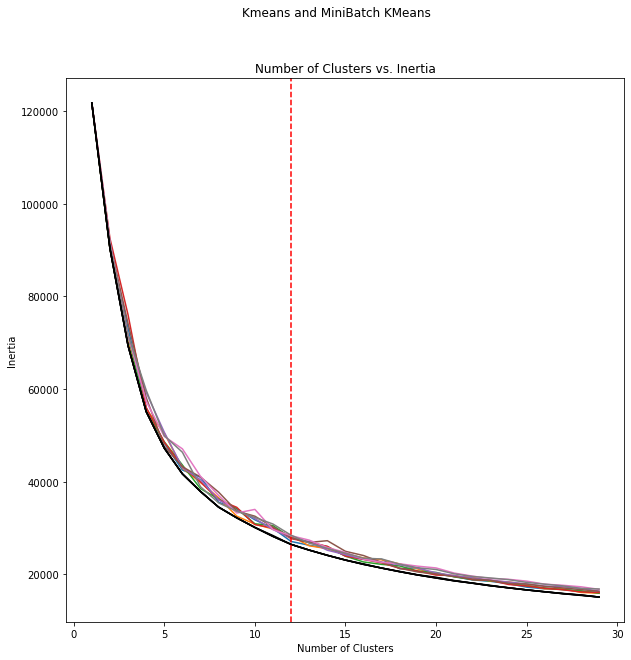

----------------------------------------------------------------------------------------------


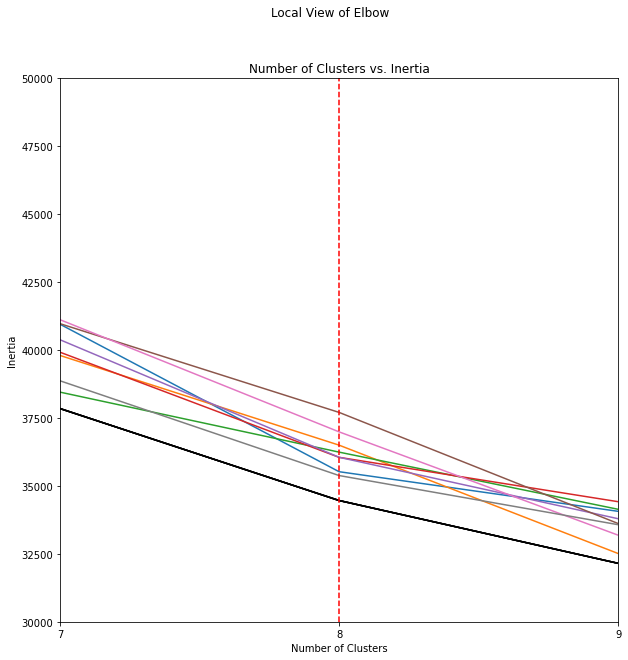

In [130]:
##Plot Number of clusters vs Inertia for kmeans and minibatch kmeans
plt.clf() 
plt.figure(figsize=(10,10))

for init in inits:
    for batches in batch:
        plt.plot(kmini_inertias.n_clusters.loc[(kmini_inertias.iloc[:,1]==init) & (kmini_inertias.iloc[:,3]==batches)], kmini_inertias.inertia.loc[(kmini_inertias.iloc[:,1]==init) & (kmini_inertias.iloc[:,3]==batches)])
for init in inits:
    for n in n_inits:
        plt.plot(kmeans_inertia.n_clusters.loc[(kmeans_inertia.iloc[:,1]==init) & (kmeans_inertia.iloc[:,2]==n)], kmeans_inertia.inertia.loc[(kmeans_inertia.iloc[:,1]==init) & (kmeans_inertia.iloc[:,2]==n)],color="black")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.suptitle("Kmeans and MiniBatch KMeans")
plt.title("Number of Clusters vs. Inertia")
plt.axvline(12, linestyle='--', color='r')
plt.show()
print("----------------------------------------------------------------------------------------------")
##zoomed in plot
plt.figure(figsize=(10,10))
for init in inits:
    for batches in batch:
        plt.plot(kmini_inertias.n_clusters.loc[(kmini_inertias.iloc[:,1]==init) & (kmini_inertias.iloc[:,3]==batches)], kmini_inertias.inertia.loc[(kmini_inertias.iloc[:,1]==init) & (kmini_inertias.iloc[:,3]==batches)])
for init in inits:
    for n in n_inits:
        plt.plot(kmeans_inertia.n_clusters.loc[(kmeans_inertia.iloc[:,1]==init) & (kmeans_inertia.iloc[:,2]==n)], kmeans_inertia.inertia.loc[(kmeans_inertia.iloc[:,1]==init) & (kmeans_inertia.iloc[:,2]==n)],color="black")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.suptitle("Local View of Elbow")
plt.title("Number of Clusters vs. Inertia")
plt.xlim(7,9)
plt.ylim(30000,50000)
plt.xticks([7,8,9],)
plt.axvline(8, linestyle='--', color='r')
plt.show()

In [109]:
##K-means that had the best results
kmeans_full = KMeans(n_clusters=8,random_state=10)
kmeans_full.fit_transform(xx)
train_df['kmeans_8']=kmeans_mini.labels_


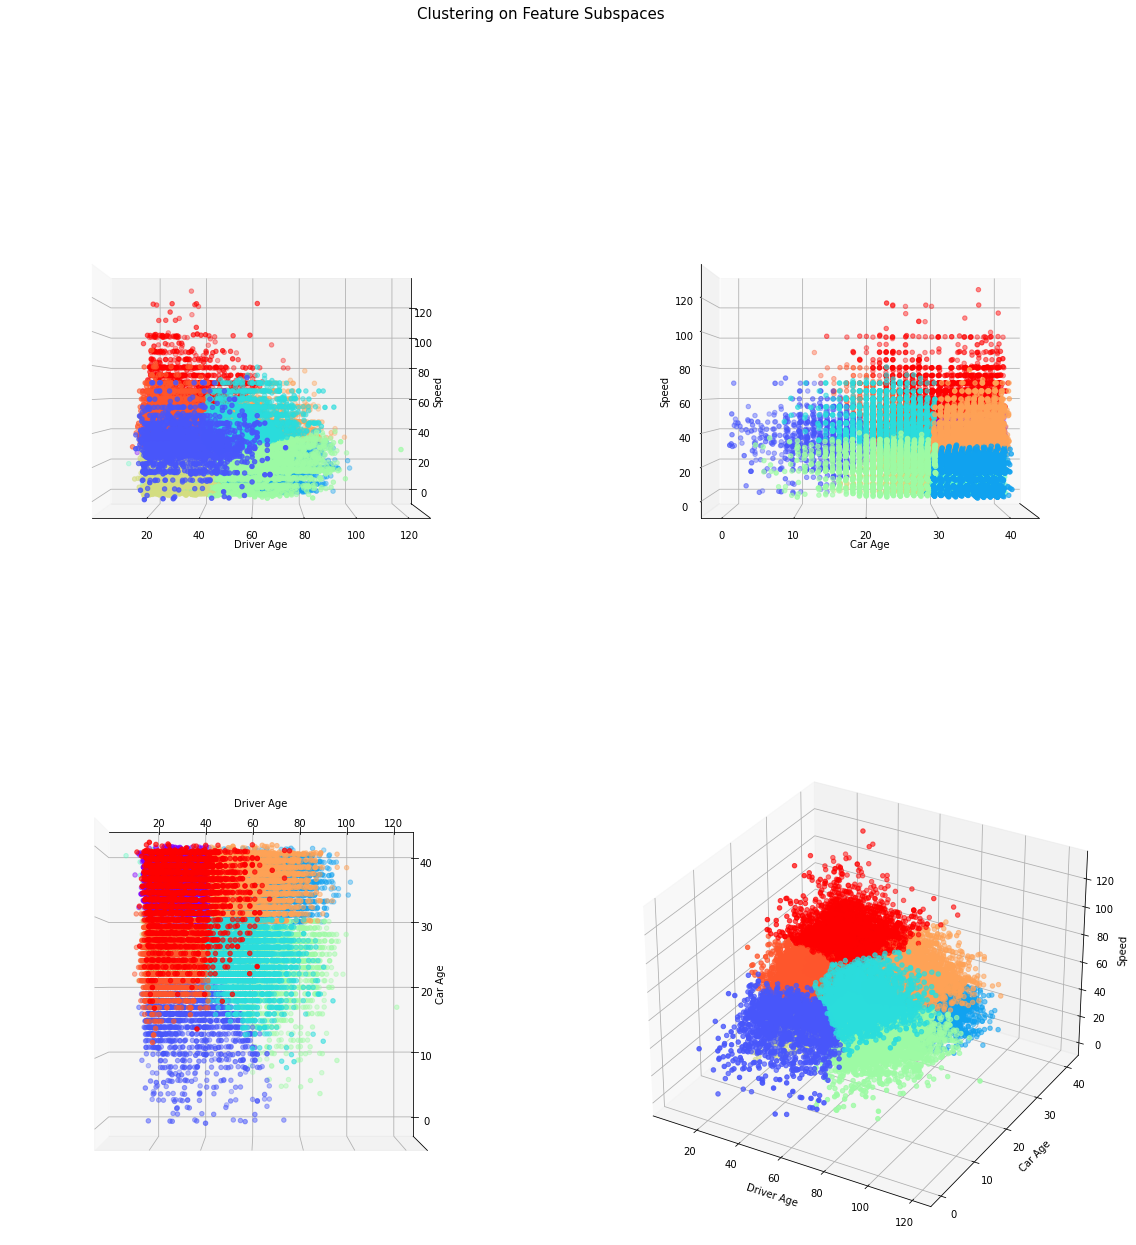

In [85]:
##3d plotting

## This does an inverse transform on the continuous variables to put them back to their original values for plotting

yy=pd.DataFrame(scaler.inverse_transform(xx[['age_im','mod_yearname_x']]),columns=['age_im','mod_yearname_x'])
yy['trav_sp_scaled']=speed_scaler.inverse_transform(xx[['trav_sp_scaled']])
yy.mod_yearname_x=yy.mod_yearname_x-1980
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(20,20))
fig.suptitle("Clustering on Feature Subspaces", fontsize=15)
#ax = plt.axes(projection='3d')
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.scatter3D(yy.iloc[:,0], yy.iloc[:,1], yy.iloc[:,2], c=kmeans_full.labels_, cmap=plt.cm.rainbow)
ax.set_xlabel("Driver Age")
ax.set_ylabel("")
ax.set_zlabel("Speed")

ax.set_yticks([])
ax.view_init(azim=270,elev=0)

##plot 2

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.scatter3D(yy.iloc[:,0], yy.iloc[:,1], yy.iloc[:,2], c=kmeans_full.labels_, cmap=plt.cm.rainbow);
ax.set_xlabel("")
ax.set_ylabel("Car Age")
ax.set_zlabel("Speed")

ax.set_xticks([])
ax.view_init(azim=0,elev=0)

##plot 3

ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.scatter3D(yy.iloc[:,0], yy.iloc[:,1], yy.iloc[:,2], c=kmeans_full.labels_, cmap=plt.cm.rainbow);
ax.set_xlabel("Driver Age")
ax.set_ylabel("Car Age")
ax.set_zlabel("")

ax.set_zticks([])
ax.view_init(azim=270,elev=90)

#plot 4
ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.scatter3D(yy.iloc[:,0], yy.iloc[:,1], yy.iloc[:,2], c=kmeans_full.labels_, cmap=plt.cm.rainbow);
ax.set_xlabel("Driver Age")
ax.set_ylabel("Car Age")
ax.set_zlabel("Speed")
plt.show()

In [111]:
##Print out top features for each cluster
holder=pd.DataFrame()
for clust in range(0,8):
    holder=pd.concat([holder,train_df.loc[train_df['kmeans_8']==clust].describe(include="object")])
holder

,alchl_imname,body_type_binned,hour_binned,int_hwyname,intersection_binned,lgtcon_imname,maxsev_binned,maxsev_imname,pcrash1_imname,regionname,...,restraint_binned,sex_imname,speeding_status,urbanicityname,vnum_lanname,vsurcondname,vtrafconname,vtrafwayname,weather_binned,wkdy_imname
count,711,711,711,711,711,711,711,711,711,711,...,711,711,711,711,711,711,711,711,711,711
unique,2,12,4,2,3,7,2,5,16,4,...,4,2,3,2,9,7,12,8,6,7
top,No Alcohol Involved,1,Morning,No,Yes,Daylight,Not Fatal,No Apparent Injury,Stopped in Roadway,South,...,Full,Male,not speeding,Urban,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Tuesday
freq,673,187,242,678,326,574,664,412,269,385,...,656,409,552,557,207,511,272,293,494,126
count,1332,1332,1332,1332,1332,1332,1332,1332,1332,1332,...,1332,1332,1332,1332,1332,1332,1332,1332,1332,1332
unique,2,12,4,2,3,6,2,5,9,4,...,4,2,3,2,8,8,6,7,6,7
top,No Alcohol Involved,1,Night,Yes,No,Daylight,Not Fatal,No Apparent Injury,Going Straight,South,...,Full,Male,not speeding,Urban,Two lanes,Dry,No Controls,"Two-Way, Divided, Positive Median Barrier",Clear,Saturday
freq,1115,534,418,707,1265,660,895,449,897,670,...,951,963,518,906,632,1051,856,680,932,211
count,772,772,772,772,772,772,772,772,772,772,...,772,772,772,772,772,772,772,772,772,772
unique,2,12,4,2,3,7,2,5,16,4,...,4,2,3,2,9,10,10,8,6,7
